# Natural images CT Inverse problems with Gaussian Noise


In [1]:
#For plotting and importing images from directories
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet, GSDRUNet 
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP, RED
from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


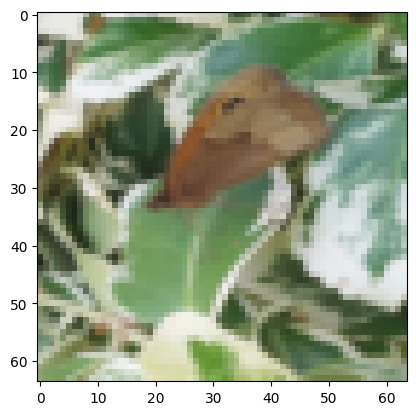

In [2]:
path = "data/butterfly.png"
image = Image.open(path)
dim = 64
transform = transforms.Compose([transforms.Resize((dim, dim)), transforms.ToTensor(),])
img = transform(image)
plt.imshow(img.permute(1, 2, 0))
img = img.reshape(1, 3, dim, dim)

torch.Size([1, 3, 64, 64])


C:\Users\as5057\AppData\Local\Temp\ipykernel_27164\4210213176.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, device=device, dtype=torch.float)


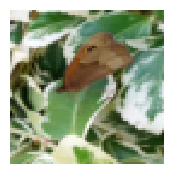

In [6]:
url = get_image_url("CBSD_0010.png")
imsize = (dim, dim)
x1 = load_url_image(url, grayscale = False).to(device)
x1 = torch.tensor(x1, device=device, dtype=torch.float)
x1 = torch.nn.functional.interpolate(x1, size= imsize)
img_size = x1.shape[1:]
print(x1.shape)
plot(img)
x = img

# Radon Transform with Gaussian noise


In [4]:
noise_level = 1
radon = dinv.physics.Tomography(
    img_width = img_size[-1],
    angles = 100,
    device = device,
    noise_model = dinv.physics.GaussianNoise(sigma = noise_level)
)

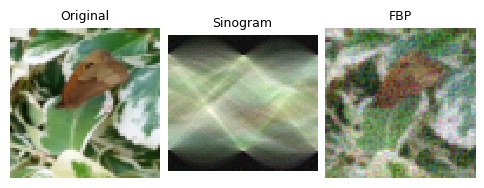

In [5]:
y = radon(x)
fbp = radon.A_dagger(y)
plot([x, y, fbp], titles = ["Original", "Sinogram", "FBP"])

In [6]:
params = {"stepsize": 0.01, "lambda": 1e-2, "g_param": noise_level}
drunet_params = {"stepsize": 0.01, "g_param": 1e-2}
dncnn_params = {"stepsize": 0.01, "g_param": 1e-2}
max_iter = 250
channels = 3
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()


In [7]:
priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)

# Gradient-step denoiser (GS-PnP)

In [9]:
class GSPnP(RED):
    r"""
    Gradient-Step Denoiser prior.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.explicit_prior = True

    def g(self, x, *args, **kwargs):
        r"""
        Computes the prior :math:`g(x)`.

        :param torch.tensor x: Variable :math:`x` at which the prior is computed.
        :return: (torch.tensor) prior :math:`g(x)`.
        """
        return self.denoiser.potential(x, *args, **kwargs)


In [10]:
gsdrunet =GSDRUNet(
    in_channels= 3,
    out_channels= 3,
    pretrained="download",
    device="cpu",
)

gsprior = GSPnP(denoiser = gsdrunet)
gs1 = {"stepsize": 0.01, "g_param": 1e-5}
gs2 = {"stepsize": 0.01, "g_param": 1e-4}
gs3 = {"stepsize": 0.01, "g_param": 1e-3}
gs4 = {"stepsize": 0.01, "g_param": 1e-2}
gsparams = {"stepsize": 0.01, "g_param": noise_level}



mgs = optim_builder(
    iteration="PGD",
    prior= gsprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo= gsparams,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

mgs.eval()

BaseOptim(
  (fixed_point): FixedPoint(
    (iterator): PGDIteration(
      (f_step): fStepPGD()
      (g_step): gStepPGD()
    )
  )
)

In [ ]:
gs1, met1 = m1(y, radon, x_gt = x, compute_metrics = True)
gs2, met2 = m2(y, radon, x_gt = x, compute_metrics = True)
gs3, met3 = m3(y, radon, x_gt = x, compute_metrics = True)
gs4, met4 = m4(y, radon, x_gt = x, compute_metrics = True)

In [12]:
xgs, met = mgs(y, radon, x_gt = x, compute_metrics = True)

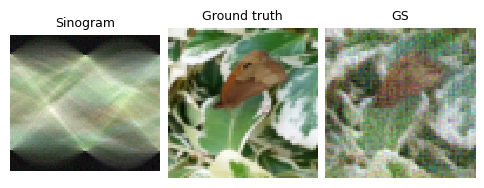

In [13]:
#f = radon.A_dagger(x)
imgs = [y, x, xgs]
plot(imgs, titles = ["Sinogram", "Ground truth", "GS"])

## Tuning DRUNet parameters

In [14]:
# noise level parameters for drunet

paramsa = {"stepsize": 0.01, "g_param": 1e-5}
paramsb = {"stepsize": 0.01, "g_param": 1e-4}
paramsc = {"stepsize": 0.01, "g_param": noise_level}
iters = 50


d1 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = iters,
    verbose = True,
    params_algo=paramsa,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

d2 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = iters,
    verbose = True,
    params_algo=paramsb,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

d3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = iters,
    verbose = True,
    params_algo=paramsc,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

def get_DPIR_params(noise_level_img, max_iter):
    r"""
    Default parameters for the DPIR Plug-and-Play algorithm.

    :param float noise_level_img: Noise level of the input image.
    """
    #max_iter = 8
    s1 = 49.0 / 255.0
    s2 = noise_level_img
    sigma_denoiser = np.logspace(np.log10(s1), np.log10(s2), max_iter).astype(
        np.float32
    )
    stepsize = (sigma_denoiser / max(0.01, noise_level_img)) ** 2
    lamb = 1 / 0.23
    return list(sigma_denoiser), list(lamb * stepsize), max_iter



#from deepinv.optim.dpir import get_DPIR_params
sigma_denoiser, stepsize, num_iters = get_DPIR_params(noise_level, iters)

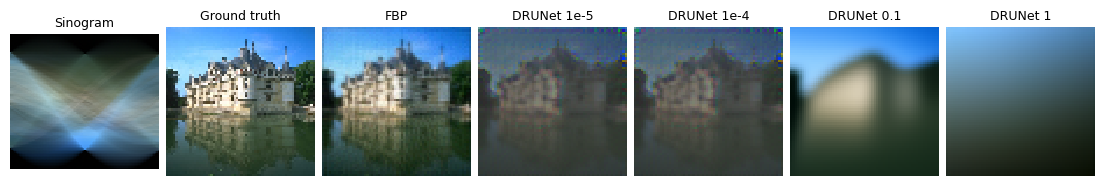

In [339]:
imgs = [y, x, fbp, dru1, dru2, dru3, dru4]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "DRUNet 1e-5", "DRUNet 1e-4", "DRUNet 0.1", "DRUNet 1"])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)



plot_psnrs_residuals(met1, '$\\sigma = 1e-5$')
plot_psnrs_residuals(met2, '$\\sigma = 1e-4$')
plot_psnrs_residuals(met3, '$\\sigma = 1e-1$')
plot_psnrs_residuals(met4, '$\\sigma = 1$')

ax1.legend()
ax2.legend()

# Initialise models (TV, BM3D, DnCNN, DRUNet)

In [16]:
#tv
model1 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = 50,
    verbose = True,
    params_algo=drunet_params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

In [17]:
x_model1, metrics1 = model1(y, radon, x_gt = x, compute_metrics = True)
x_model2, metrics2 = model2(y, radon, x_gt = x, compute_metrics = True)
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = x, compute_metrics = True)

Iteration 55, current converge crit. = 4.09E-06, objective = 1.00E-05 


In [18]:
x_model3, metrics3 = model3(y, radon, x_gt = x, compute_metrics = True)

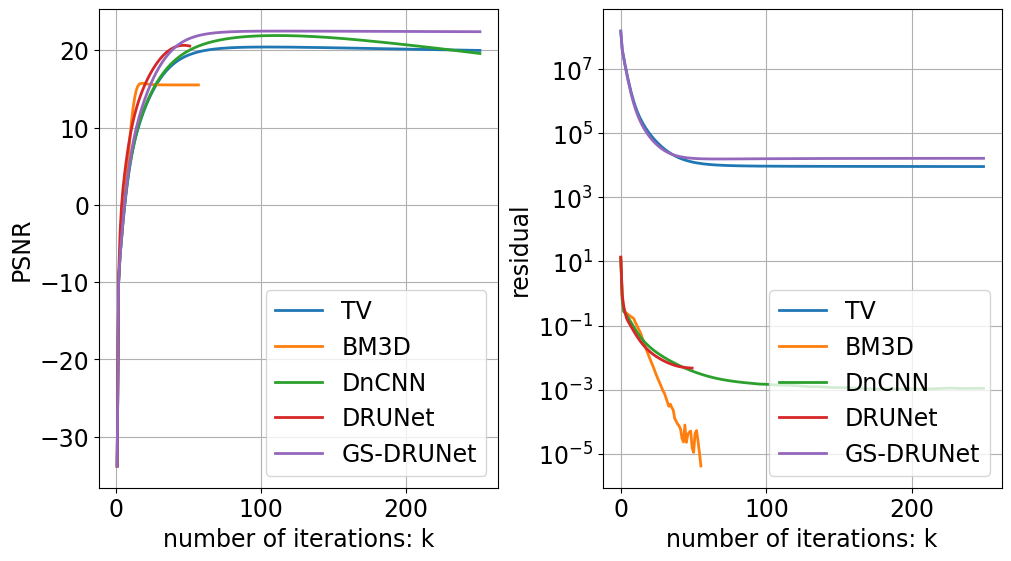

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)

    return round(psnrs[-1], 2)


tvpsnr = plot_psnrs_residuals(metrics1, 'TV')
bm3dpsnr = plot_psnrs_residuals(metricsbm3d, 'BM3D')
dncnnpsnr = plot_psnrs_residuals(metrics2, 'DnCNN')
drunetpsnr = plot_psnrs_residuals(metrics3, 'DRUNet')
gspsnr = plot_psnrs_residuals(met, 'GS-DRUNet')

psnr_list = [tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gspsnr]

ax1.legend()
ax2.legend()


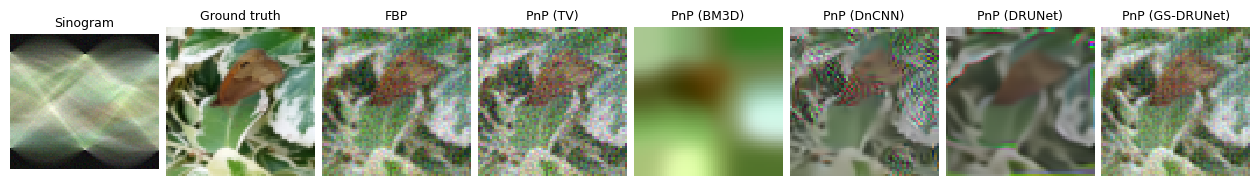

In [20]:
imgs = [y, x, fbp, x_model1, x_modelbm3d, x_model2, x_model3, xgs]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)", "PnP (GS-DRUNet)"])

In [48]:
def plt_ready(ground_truth, y, x_tv, x_bm3d, x_dncnn, x_drunet, x_gs, imsize):
    y = y.squeeze(0)
    sinogram = y.permute(1, 2, 0).numpy()
    gt = ground_truth.squeeze(0)
    gt = gt.permute(1, 2, 0).numpy()
    #fbp = FBP.view(imsize)
    tv_x = x_tv.squeeze(0)
    tv_x = tv_x.permute(1, 2, 0).numpy()
    bm3d_x = x_bm3d.squeeze(0)
    bm3d_x = bm3d_x.permute(1, 2, 0).numpy()
    dncnn_x = x_dncnn.squeeze(0)
    dncnn_x = dncnn_x.permute(1, 2, 0).numpy()
    drunet_x = x_drunet.squeeze(0)
    drunet_x = drunet_x.permute(1, 2, 0).numpy()
    gs_x = x_gs.squeeze(0)
    gs_x = gs_x.permute(1, 2, 0).detach().numpy()

    return sinogram, gt, tv_x, bm3d_x, dncnn_x, drunet_x, gs_x

def plotting_estimates(gt, x1, x2, x3, x4, x5, psnrs_list):
    size = 15
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    axs[0, 0].set_title("Ground Truth")
    axs[0, 0].imshow(gt, cmap='gray')
    #axs[0, 1].set_title("FBP")
    #axs[0, 1].imshow(fbp, cmap='gray')
    axs[0, 1].set_title(f'TV \n PSNR: {psnrs_list[0]:.2f} dB', fontsize = size)
    axs[0, 1].imshow(x1, cmap='gray')
    axs[0, 2].set_title(f'BM3D \n PSNR: {psnrs_list[1]:.2f} dB', fontsize = size)
    axs[0, 2].imshow(x2, cmap='gray')
    axs[1, 0].set_title(f'PnP (DnCNN) \n PSNR: {psnrs_list[2]:.2f} dB', fontsize = size)
    axs[1, 0].imshow(x3, cmap='gray')
    axs[1, 1].set_title(f'PnP (DRUNet) \n PSNR: {psnrs_list[3]:.2f} dB', fontsize = size)
    axs[1, 1].imshow(x4, cmap='gray')
    axs[1, 2].set_title(f'PnP (GS-DRUNet) \n PSNR: {psnrs_list[4]:.2f} dB', fontsize = size)
    axs[1, 2].imshow(x5, cmap='gray')

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')



imsize = (3, 64, 64)


In [30]:
xgs.shape

torch.Size([1, 3, 64, 64])

In [45]:
sinogram, ground_truth, x_tv, x_bm3d, x_dncnn, x_drunet, x_gs = plt_ready(x, y, x_model1, x_modelbm3d, x_model2, x_model3, xgs, imsize)
#fig, axs = plt.subplots(1, 2, figsize=(10, 6.5))
#axs[0].imshow(sinogram, cmap = 'gray')
#axs[0].set_title("Sinogram")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


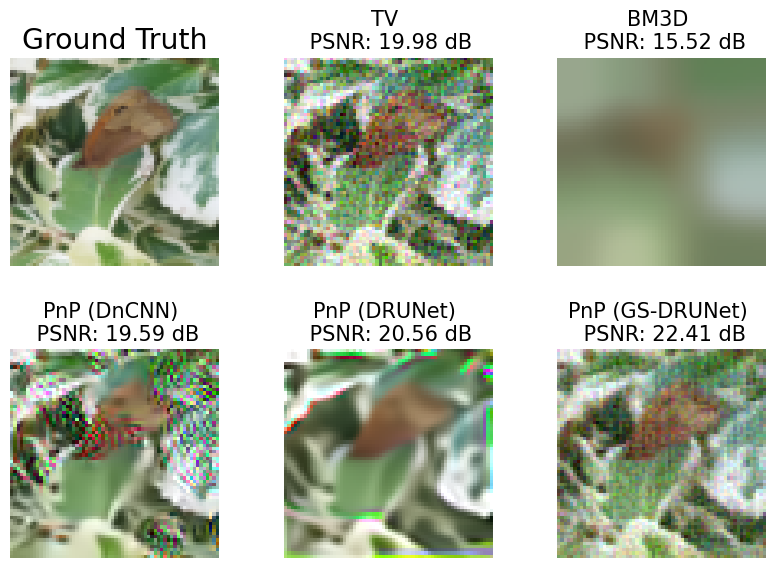

In [49]:
plotting_estimates(ground_truth, x_tv, x_bm3d, x_dncnn, x_drunet, x_gs, psnr_list)

# PnP-ADMM with the same priors

In [151]:
params = {"stepsize": 0.01, "lambda": 1, "beta": 1, "g_param": noise_level}
ADMM1 = optim_builder(
    iteration="ADMM",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
ADMM2 = optim_builder(
    iteration="ADMM",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
ADMM3 = optim_builder(
    iteration="ADMM",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

ADMMbm3d = optim_builder(
    iteration="ADMM",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [152]:
admm_model1, metrics_admm_1 = ADMM1(y, radon, x_gt = x, compute_metrics = True)
admm_model2, metrics_admm_2 = ADMM2(y, radon, x_gt = x, compute_metrics = True)
admm_model3, metrics_admm_3 = ADMM3(y, radon, x_gt = x, compute_metrics = True)
admm_modelbm3d, metrics_admm_bm3d = ADMMbm3d(y, radon, x_gt = x, compute_metrics = True)

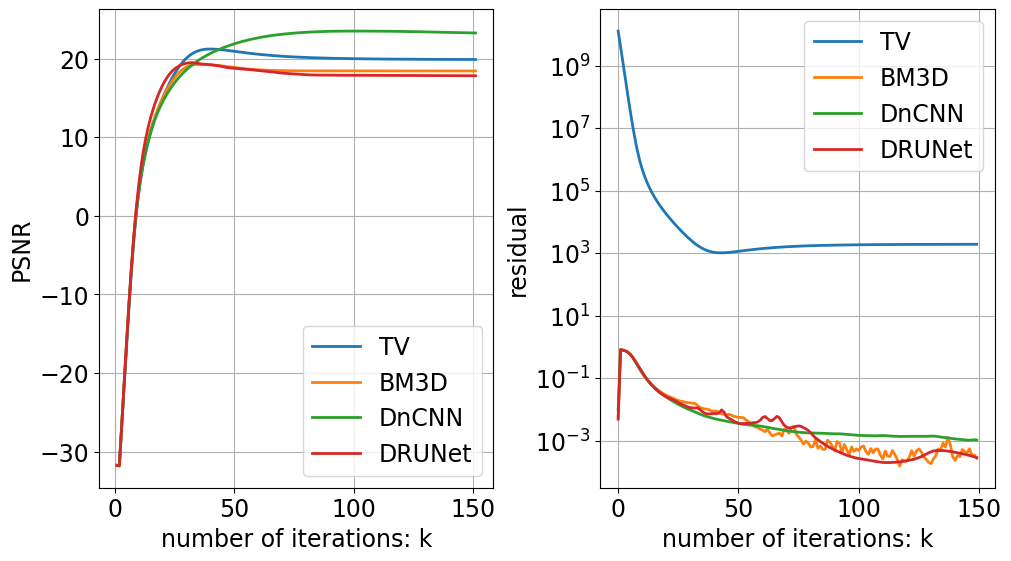

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
plot_psnrs_residuals(metrics_admm_1, 'TV')
plot_psnrs_residuals(metrics_admm_bm3d, 'BM3D')
plot_psnrs_residuals(metrics_admm_2, 'DnCNN')
plot_psnrs_residuals(metrics_admm_3, 'DRUNet')

ax1.legend()
ax2.legend()

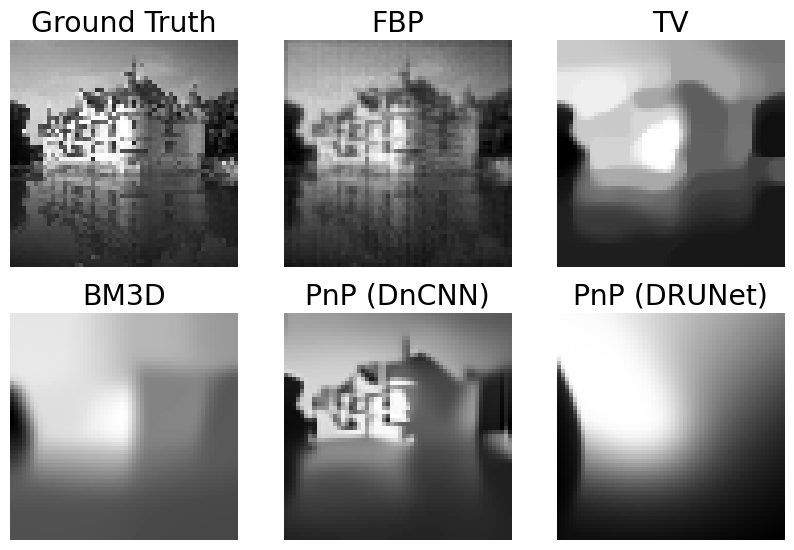

In [119]:
imsize = (56, 56)
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(x, y, fbp, admm_model1, admm_modelbm3d, admm_model2, admm_model3, imsize)
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet)